# Comparación de PHL con otros métodos de selección de instancias

In [27]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/pima.csv'
target = 'Outcome'


SEED = 2025
np.random.seed(SEED)

PROFILING = True # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/pima/' if not PROFILING else '../results/pima_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [28]:
df = pd.read_csv(dbpath)

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (768, 9)


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [29]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

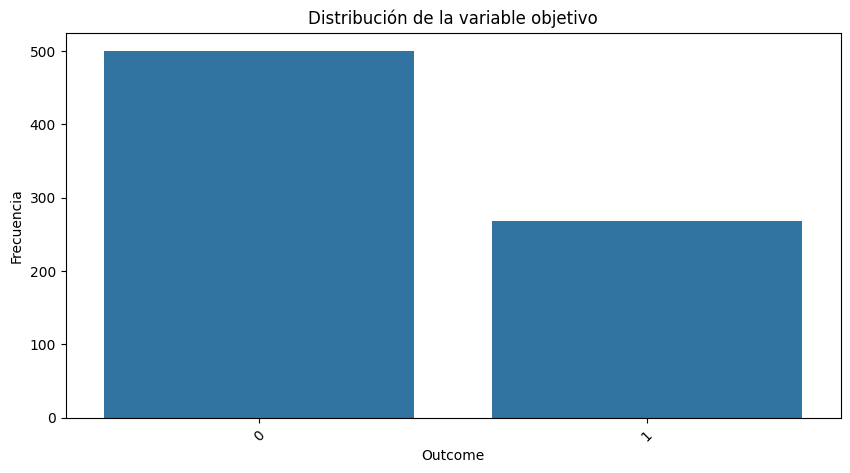

In [30]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [31]:
if PROFILING and len(df) > 1000:
    df = df.sample(1000, random_state=SEED)

In [32]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [33]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
xgb = XGBClassifier(n_estimators=100, random_state=SEED)

In [34]:
"""
# import pipeline
knn_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', knn)
])

rf_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf)
])

xgb_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb)
])
"""

"\n# import pipeline\nknn_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', knn)\n])\n\nrf_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', rf)\n])\n\nxgb_pl = Pipeline([\n    ('scaler', StandardScaler()),\n    ('classifier', xgb)\n])\n"

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
def reduce(X,y,perc,method):
    if method == 'SRS':
        X_red, y_red = srs_selection(X,y,perc)
    if method == 'CLC':
        X_red, y_red = clc_selection(X,y,perc)
    if method == 'PHL':
        X_red, y_red = phl_selection(X, y, 0.05, perc, 'restrictedDim', 2, 'representative')
    return X_red, y_red

models = {'KNN': knn, 'RF': rf, 'XGB': xgb}
reduction_methods = {'SRS': lambda X,y,perc: srs_selection(X,y,perc), 
                     'CLC': lambda X,y,perc: clc_selection(X,y,perc), 
                     'PHL': lambda X,y,perc: phl_selection(X,y,perc=perc, topological_radius=0.05, scoring_version='restrictedDim', dimension=1, landmark_type='representative')}

reduction_methods_without_perc = {'CNN': lambda X,y: cnn_selection(X,y), 
                                'DROP3': lambda X,y: drop3_selection(X,y)}

all_reduction_methods = reduction_methods | reduction_methods_without_perc

percentages = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]
metrics = ['reduction_ratio', 'representativeness', 'accuracy', 'f1', 'training_time', 'reduction_time']

## Test de hiperparámetros de PHL

In [37]:
phl_results = pd.DataFrame(columns=['model', 'reduction_method', 'mode', 'dimensions', 'max_dimension', 'percentage', 'delta'] + metrics)
deltas = [0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 1.0]
modes = ['representative', 'vital'] # if not PROFILING else ['representative']
dimensions = [(1, 'restrictedDim'), (2, 'multiDim'), (0, 'restrictedDim')] # if not PROFILING else [(1, 'restrictedDim')]

if os.path.exists(results_folder + '/phl_results.csv'):
    phl_results = pd.read_csv(results_folder + '/phl_results.csv')
else:
    for model_name in models.keys():
        for mode in modes:
            for dimension, scoring_version in dimensions:
                for percentage in percentages:
                    for delta in deltas:
                        # Reduce the dataset
                        t0 = time.time()
                        X_red, y_red = phl_selection(X_train_scaled, y_train, delta, percentage, scoring_version, dimension, mode)
                        reduction_time = time.time() - t0

                        # Fit the model
                        t0 = time.time()
                        model = models[model_name]
                        model.fit(X_red, y_red)
                        training_time = time.time() - t0

                        # Evaluate the model
                        y_pred_test = model.predict(X_test_scaled)
                        accuracy = accuracy_score(y_test, y_pred_test)
                        f1 = f1_score(y_test, y_pred_test, average='weighted')

                        # Calculate representativeness
                        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                        # Store the results
                        phl_results = phl_results.append({
                            'model': model_name,
                            'reduction_method': f'PHL',
                            'mode': mode,
                            'dimensions': scoring_version,
                            'max_dimension': dimension,
                            'percentage': percentage,
                            'delta': delta,
                            'reduction_ratio': len(y_red) / len(y_train),
                            'representativeness': epsilon,
                            'accuracy': accuracy,
                            'f1': f1,
                            'training_time': training_time,
                            'reduction_time': reduction_time,
                        }, ignore_index=True)
    # Save the results
    phl_results.to_csv(f'{results_folder}/phl_results.csv', index=False)

In [38]:
phl_results

model reduction_method            mode     dimensions  max_dimension  \
0     KNN              PHL  representative  restrictedDim              1   
1     KNN              PHL  representative  restrictedDim              1   
2     KNN              PHL  representative  restrictedDim              1   
3     KNN              PHL  representative  restrictedDim              1   
4     KNN              PHL  representative  restrictedDim              1   
..    ...              ...             ...            ...            ...   
751   XGB              PHL           vital  restrictedDim              0   
752   XGB              PHL           vital  restrictedDim              0   
753   XGB              PHL           vital  restrictedDim              0   
754   XGB              PHL           vital  restrictedDim              0   
755   XGB              PHL           vital  restrictedDim              0   

     percentage     delta  reduction_ratio  representativeness  accuracy  \
0          0.05  0.006067         0.048860            4.735926  0.668831   
1          0.10  0.006067         0.099349            4.645102  0.688312   
2          0.20  0.006067         0.200326            3.722782  0.714286   
3          0.30  0.006067         0.301303            3.305408  0.694805   
4          0.50  0.006067         0.498371            3.256636  0.707792   
..          ...       ...              ...                 ...       ...   
751        0.20  1.213402         0.200326            4.559714  0.681818   
752        0.30  1.213402         0.301303            4.559714  0.714286   
753        0.50  1.213402         0.498371            4.559714  0.720779   
754        0.75  1.213402         0.750814            4.090081  0.688312   
755        0.90  1.213402         0.899023            3.722782  0.746753   

           f1  training_time  reduction_time  
0    0.659063       0.000762        0.021672  
1    0.682994       0.000659        0.021651  
2    0.699472       0.000704        0.021689  
3    0.685803       0.000686        0.021688  
4    0.697487       0.000751        0.021699  
..        ...            ...             ...  
751  0.679498       0.019264        0.056226  
752  0.716624       0.023525        0.056225  
753  0.723097       0.027534        0.056243  
754  0.690083       0.033910        0.056257  
755  0.747051       0.036247        0.056282  

[756 rows x 13 columns]

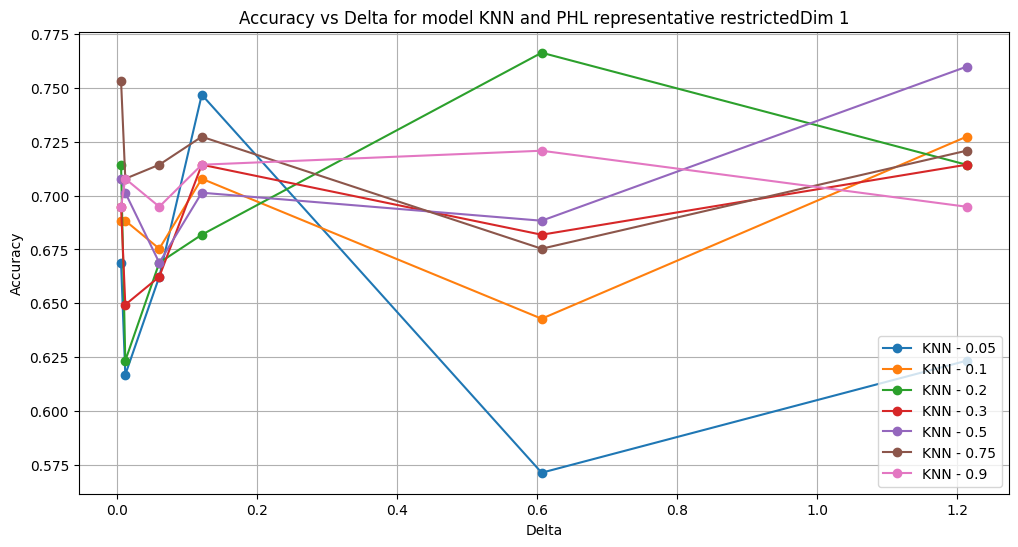

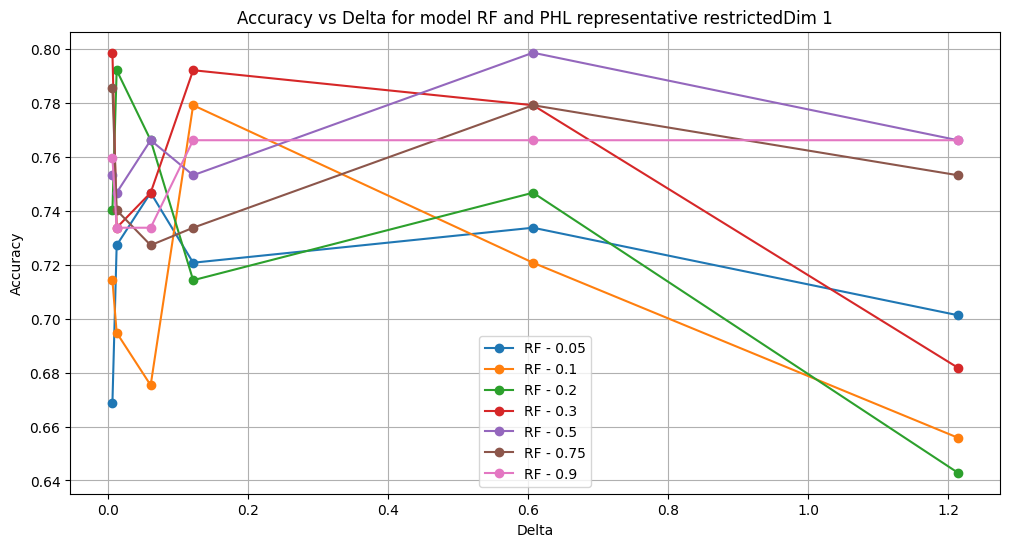

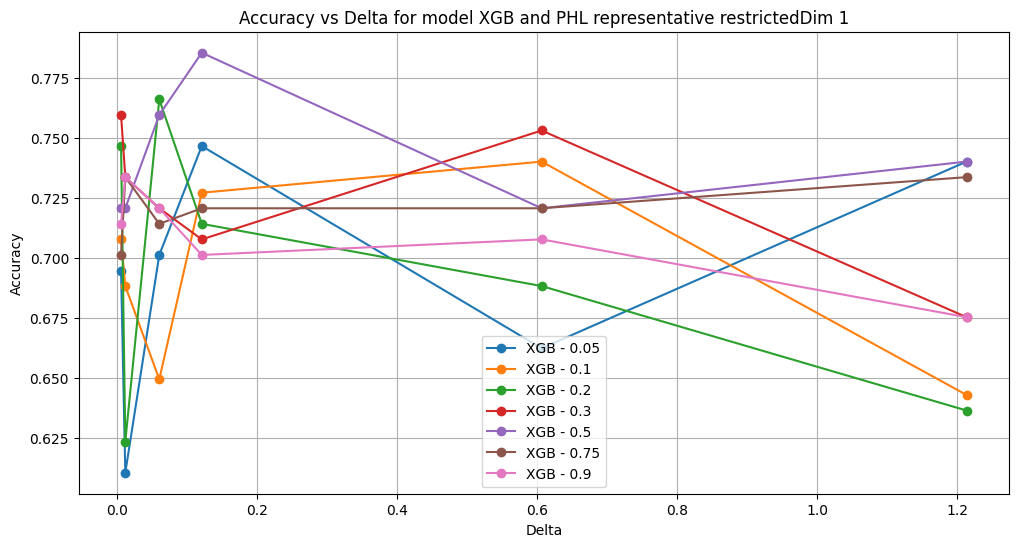

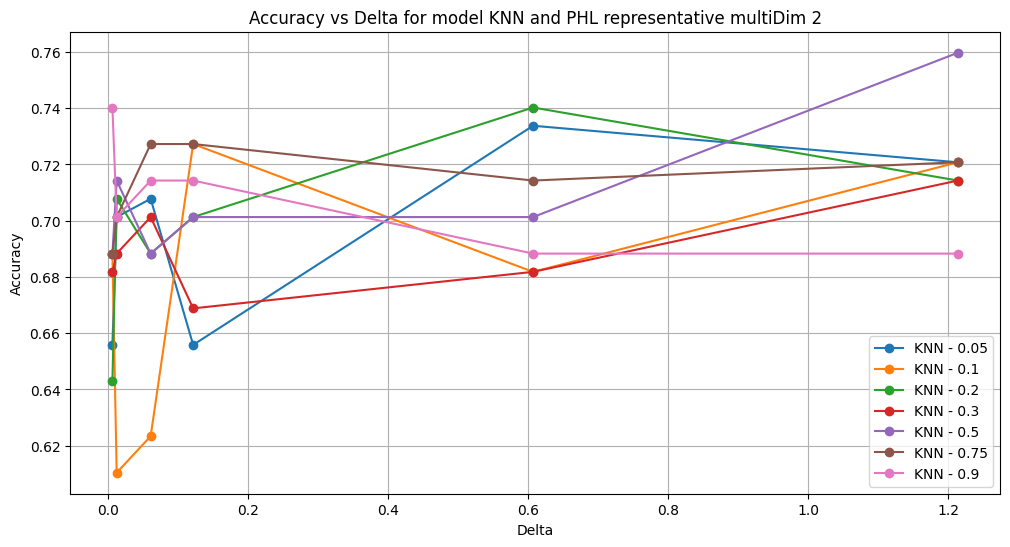

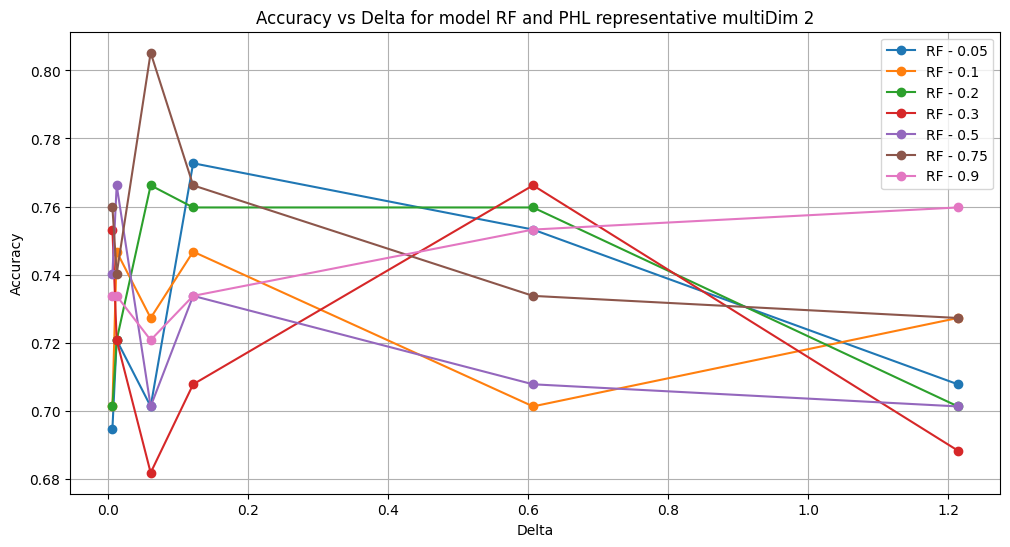

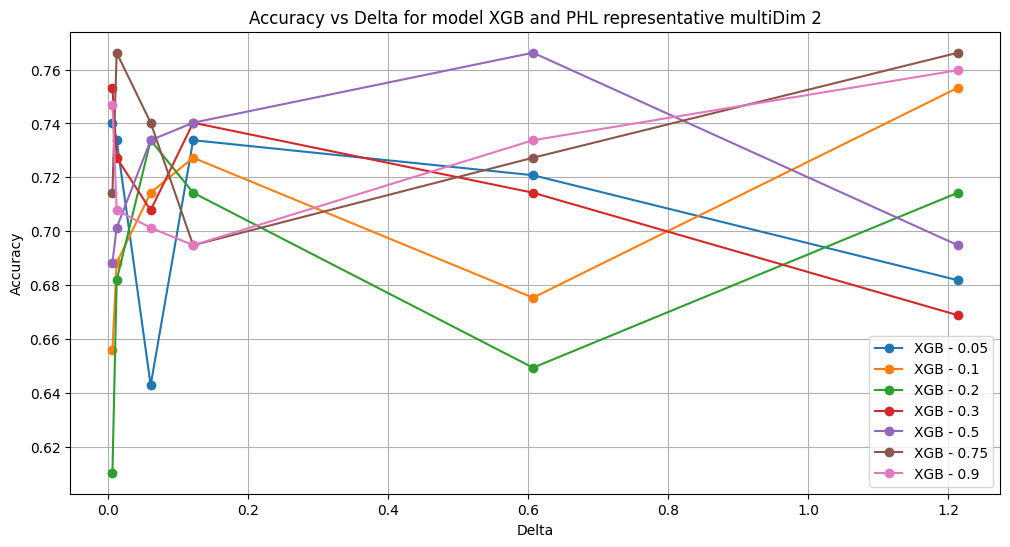

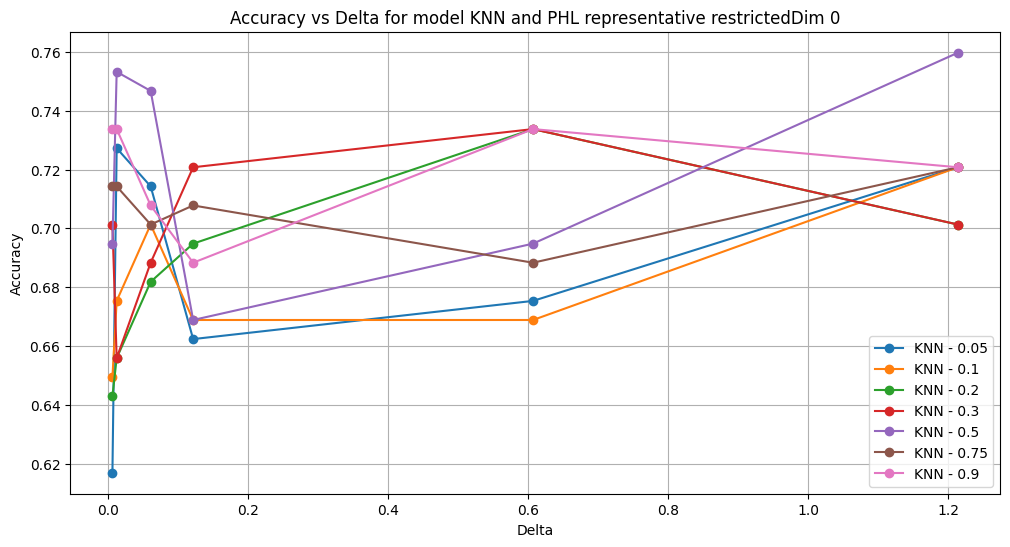

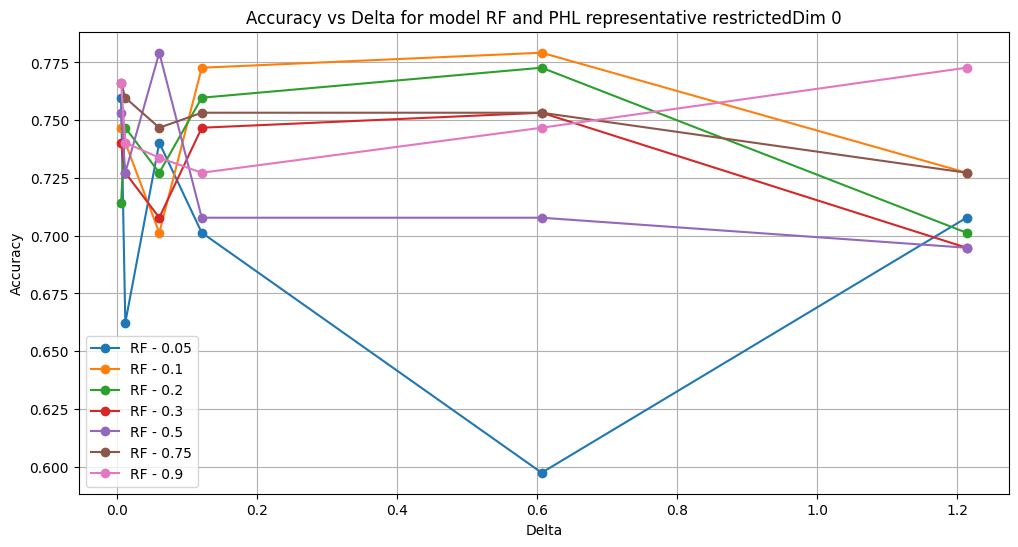

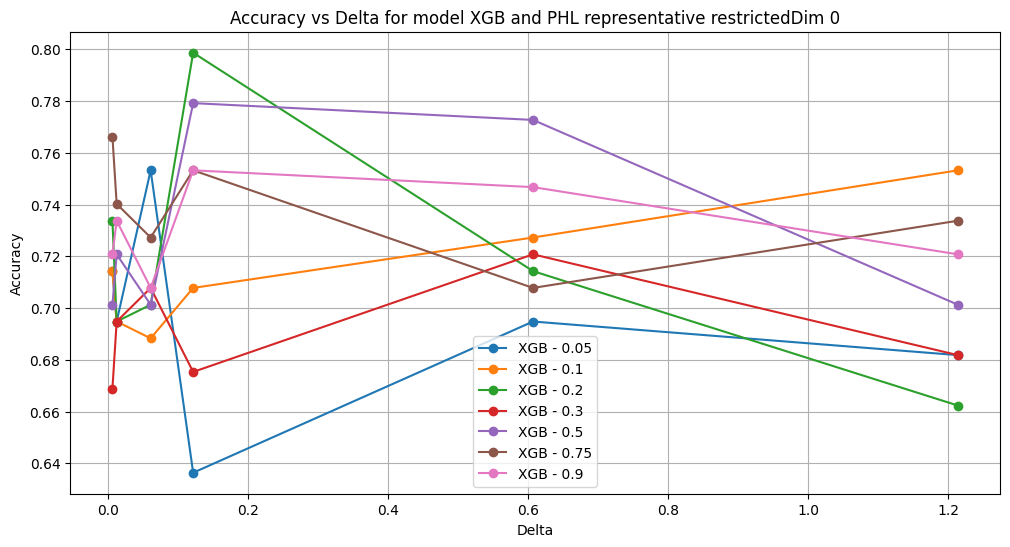

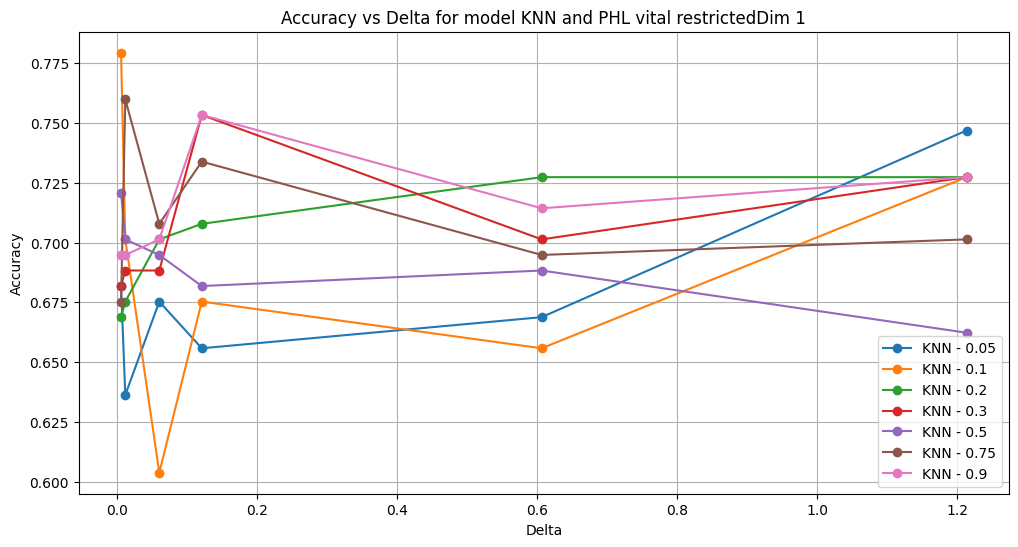

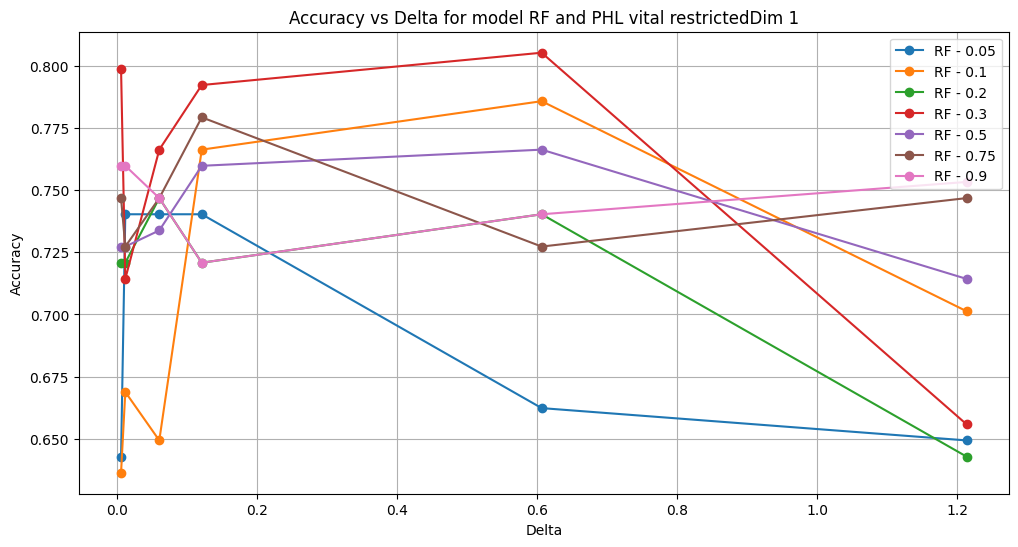

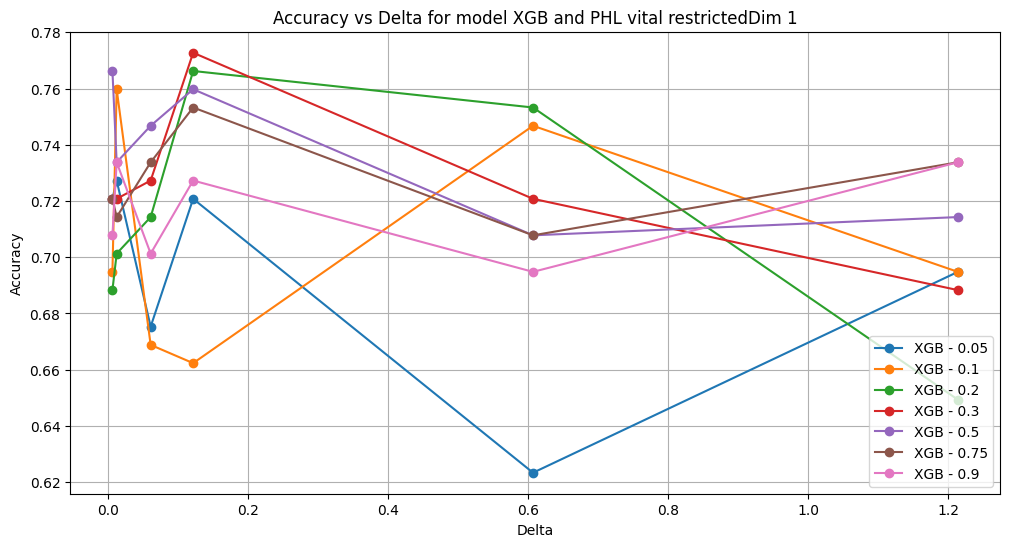

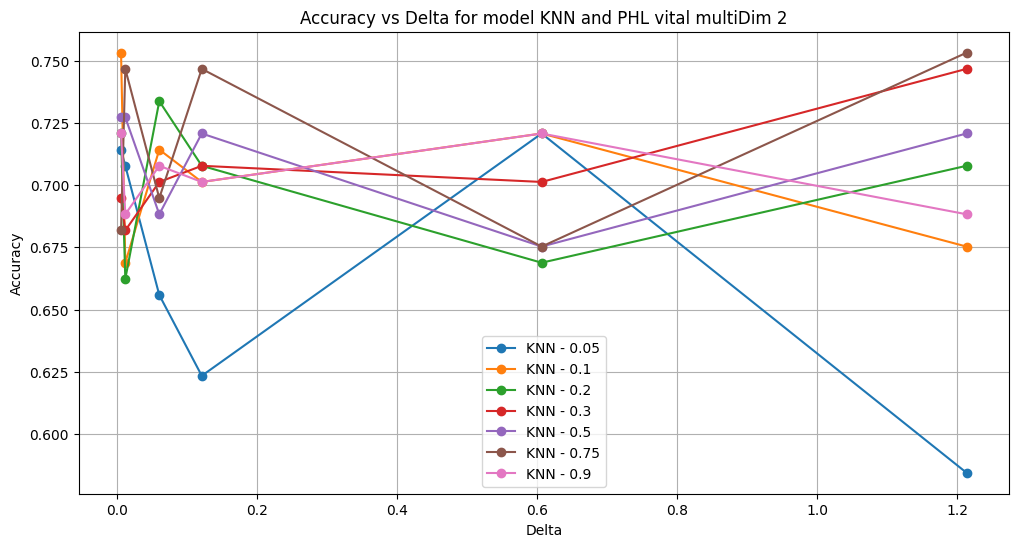

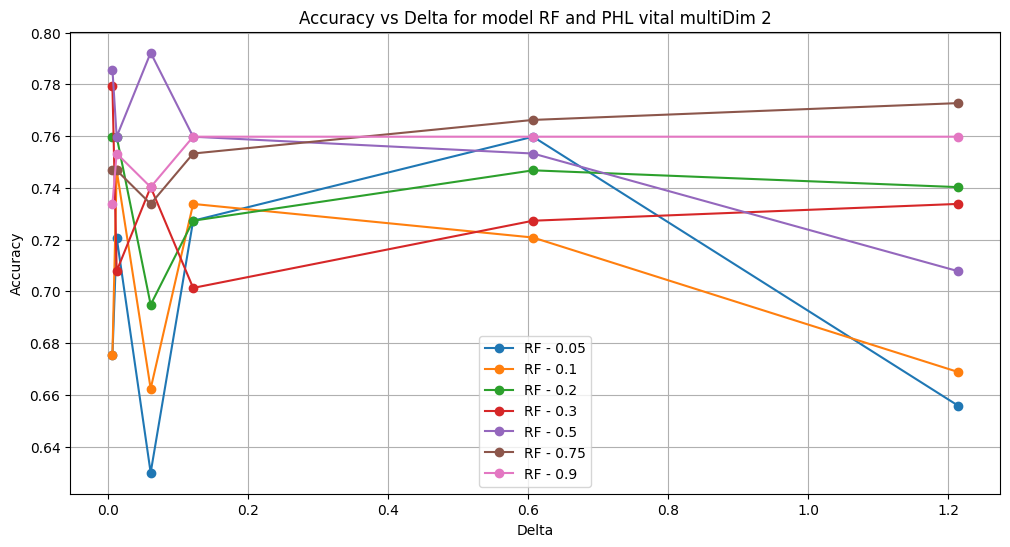

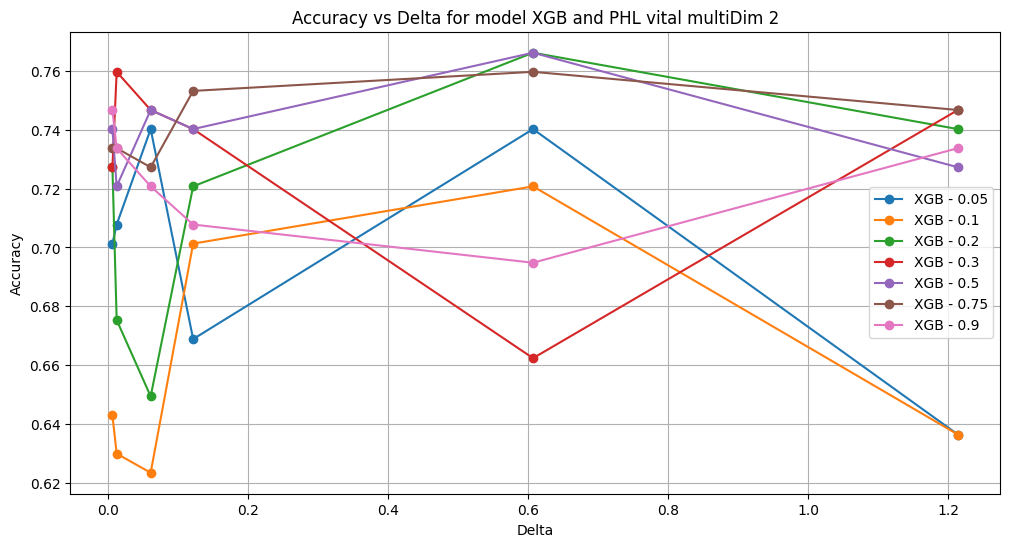

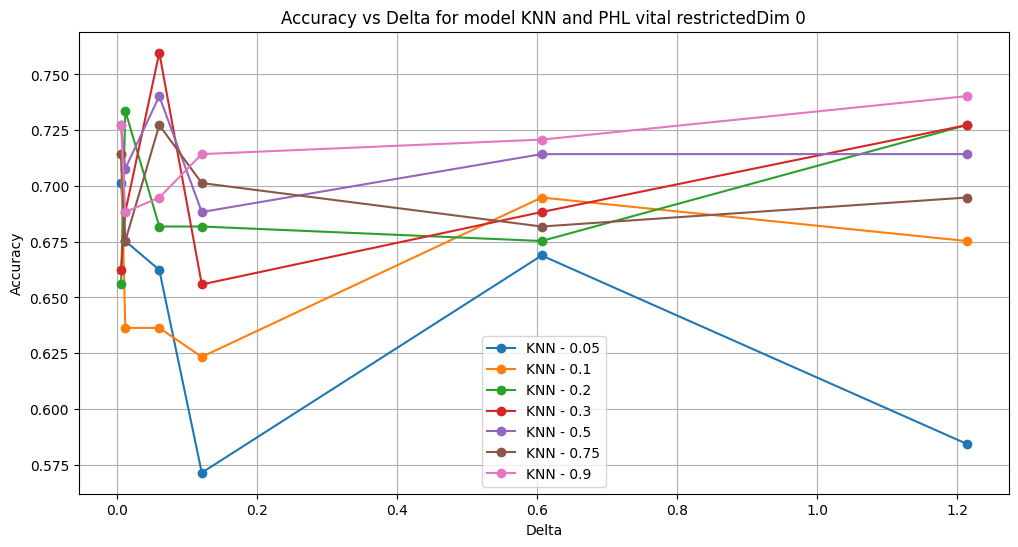

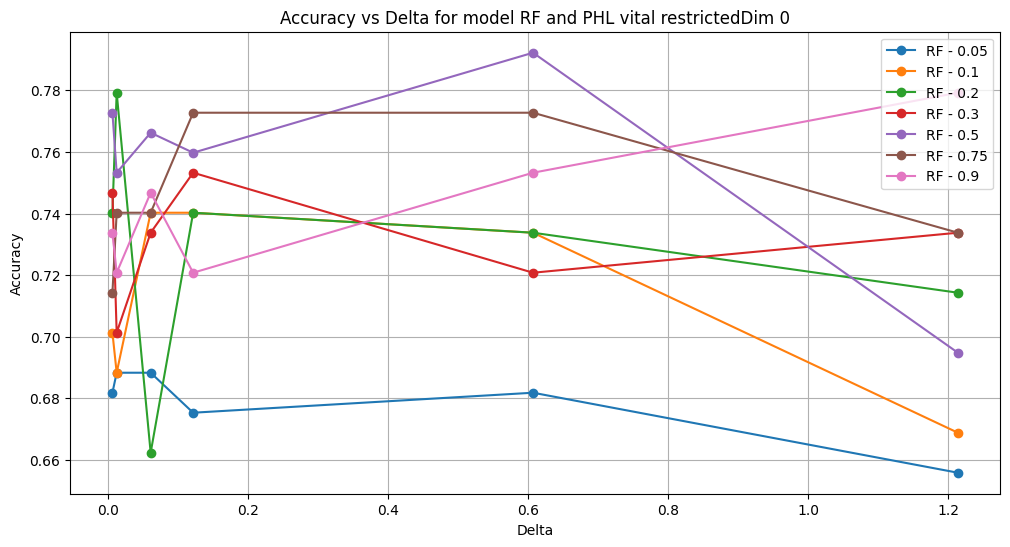

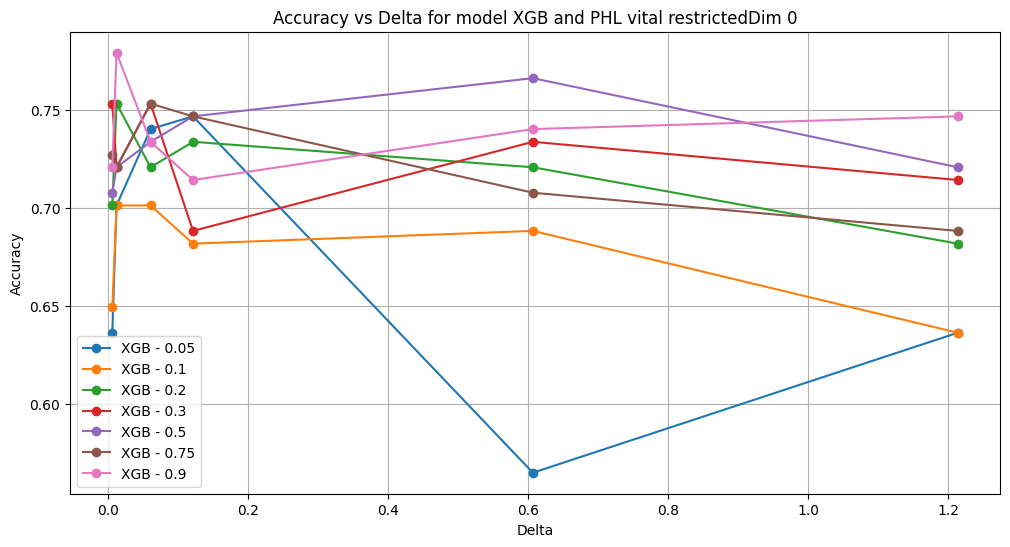

In [39]:
# Show accuracy vs delta for each model
for mode in modes:
    for dimension, scoring_version in dimensions:
        for model_name in models.keys():
            plt.figure(figsize=(12, 6))
            for percentage in percentages:
                plt.plot(phl_results[(phl_results['model'] == model_name) & 
                                     (phl_results['mode'] == mode) & 
                                     (phl_results['dimensions'] == scoring_version) & 
                                     (phl_results['max_dimension'] == dimension) & 
                                     (phl_results['percentage'] == percentage)]
                                     ['delta'],
                        phl_results[(phl_results['model'] == model_name) & 
                                    (phl_results['percentage'] == percentage) &
                                    (phl_results['mode'] == mode) & 
                                    (phl_results['dimensions'] == scoring_version) & 
                                    (phl_results['max_dimension'] == dimension)]
                                    ['accuracy'],
                        label=f'{model_name} - {percentage}', marker='o')
                plt.title(f'Accuracy vs Delta for model {model_name} and PHL {mode} {scoring_version} {dimension}')
                plt.xlabel('Delta')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid()
            plt.savefig(f'{results_folder}/accuracy_vs_delta_{model_name}_{mode}_{scoring_version}_{dimension}.png')
            plt.show()

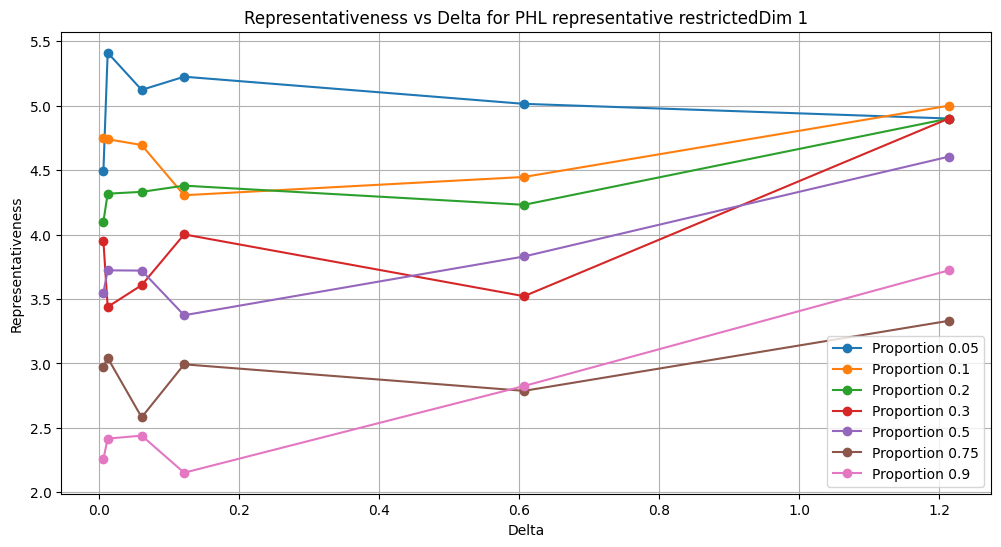

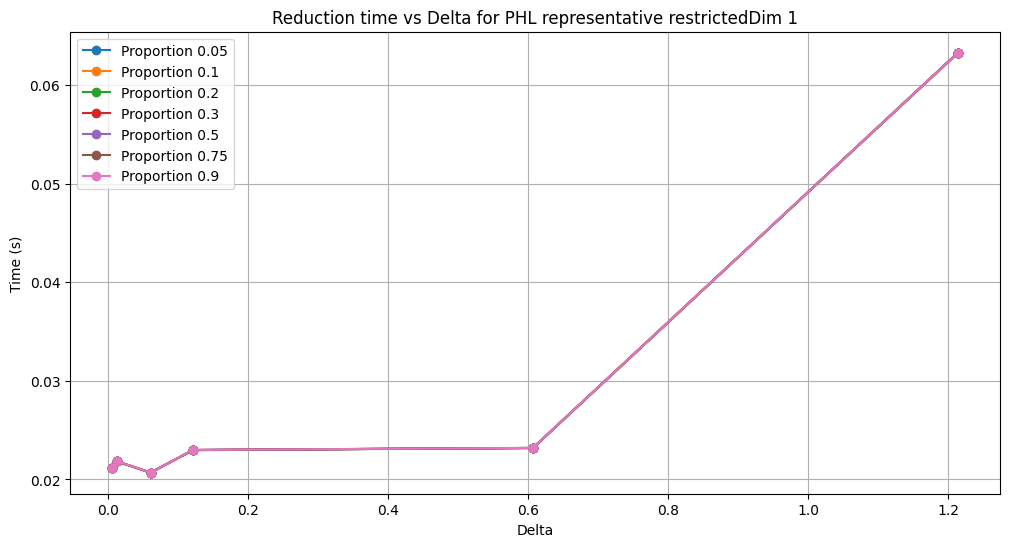

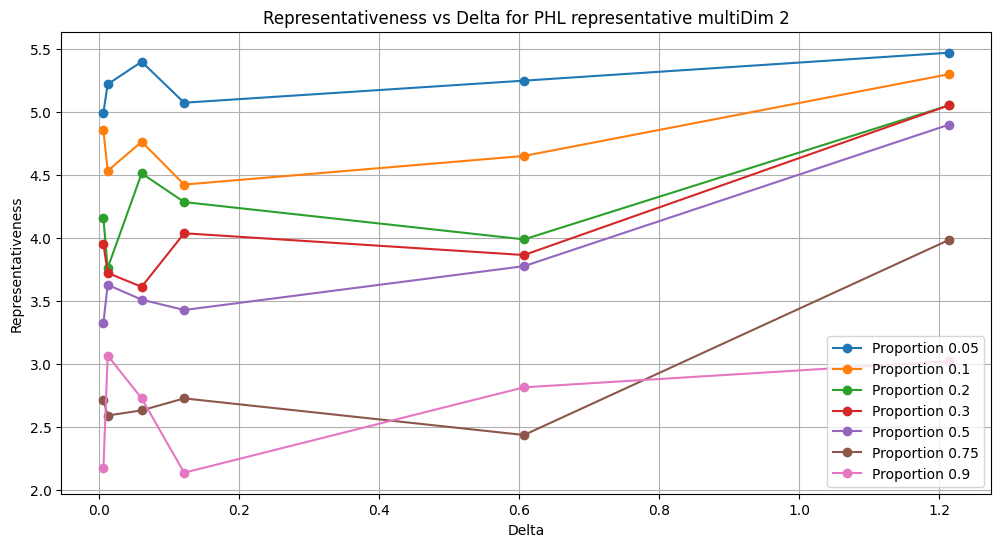

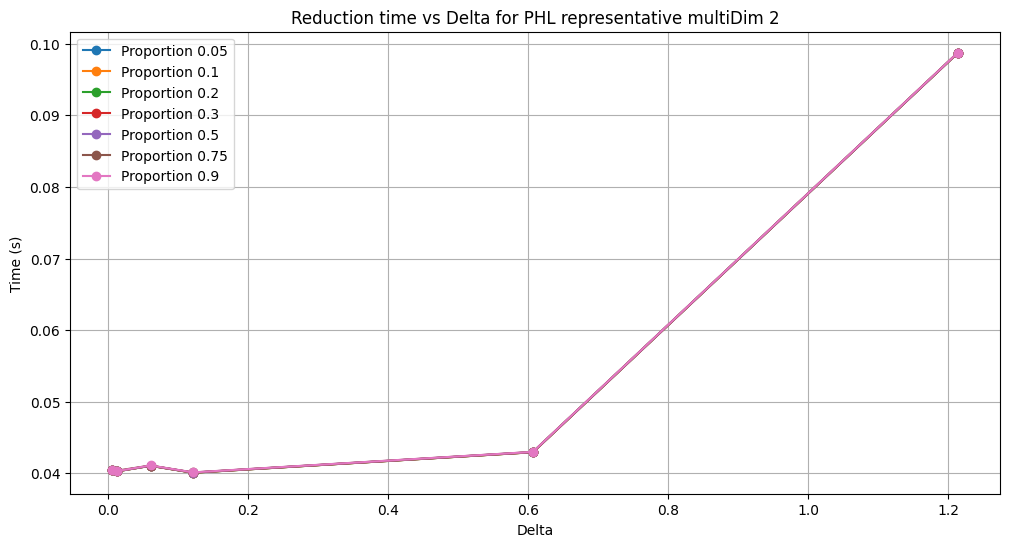

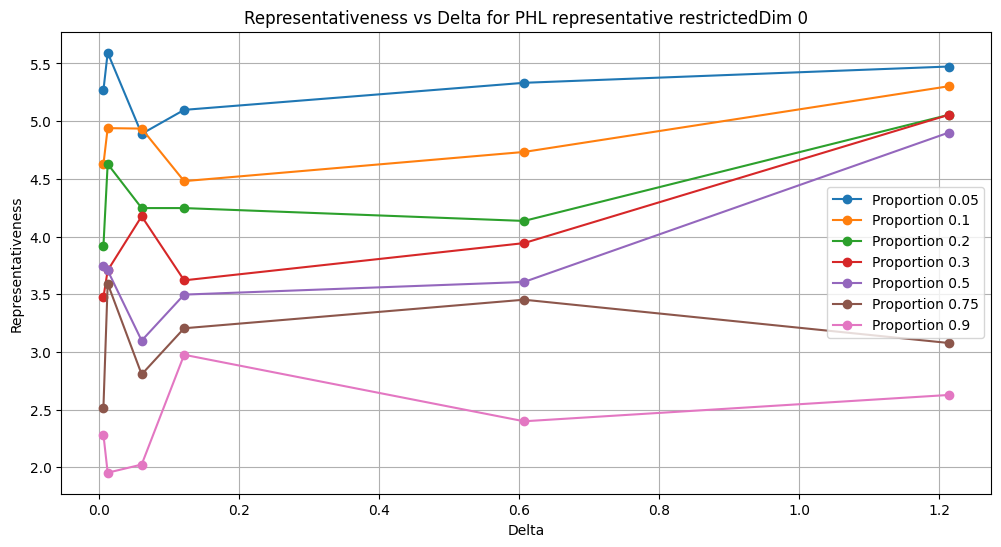

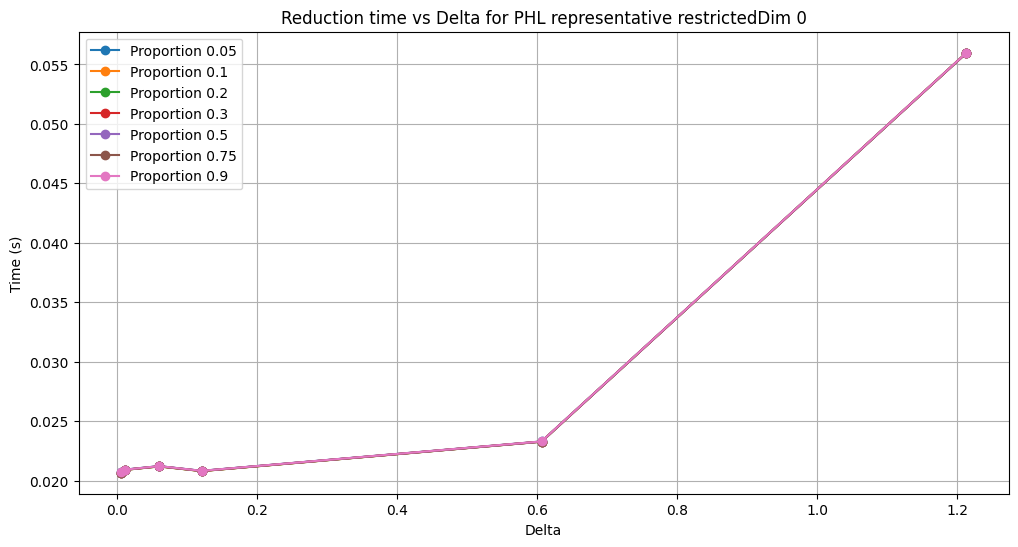

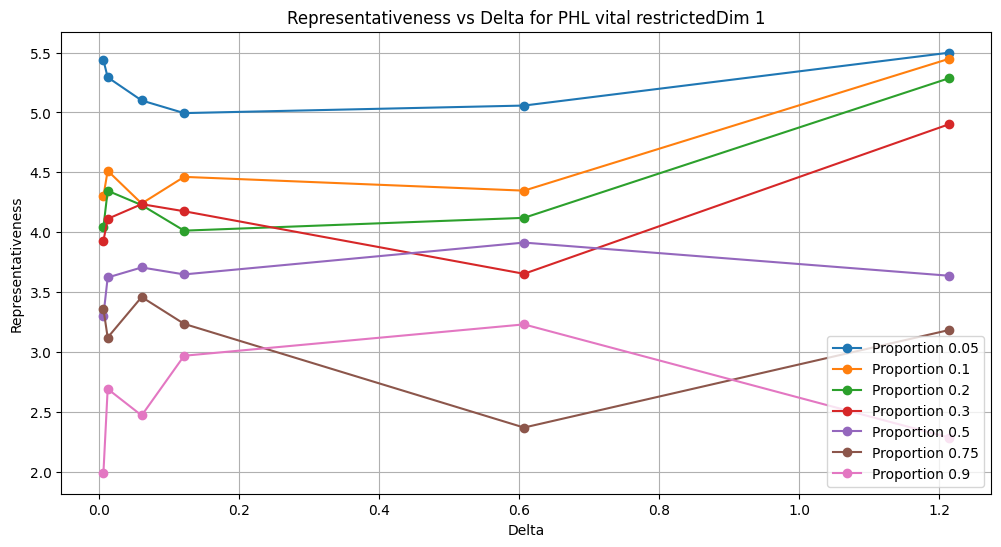

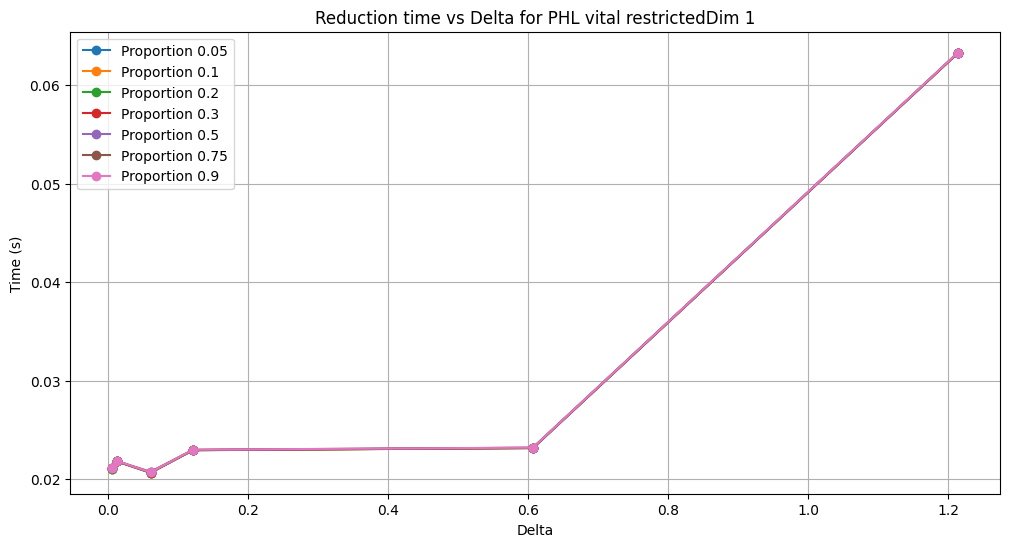

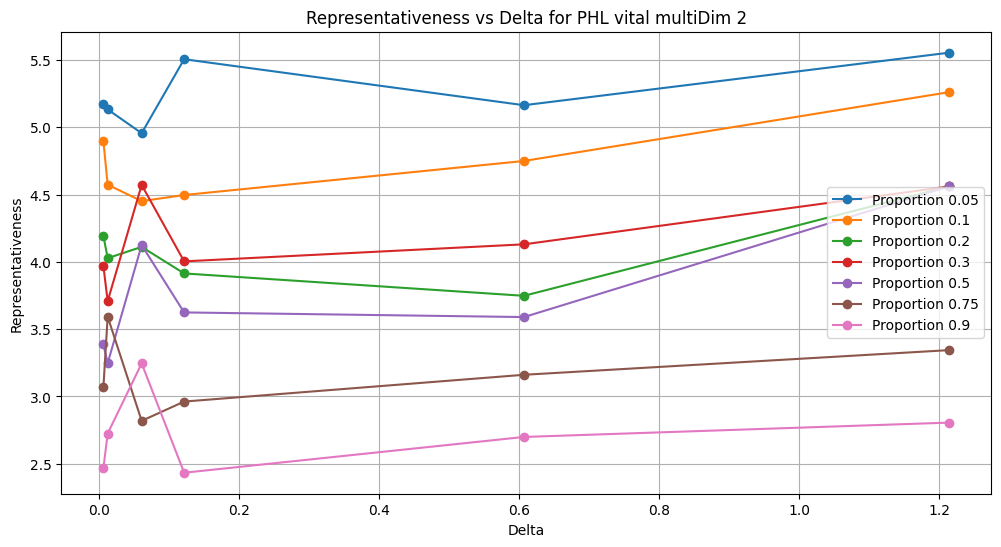

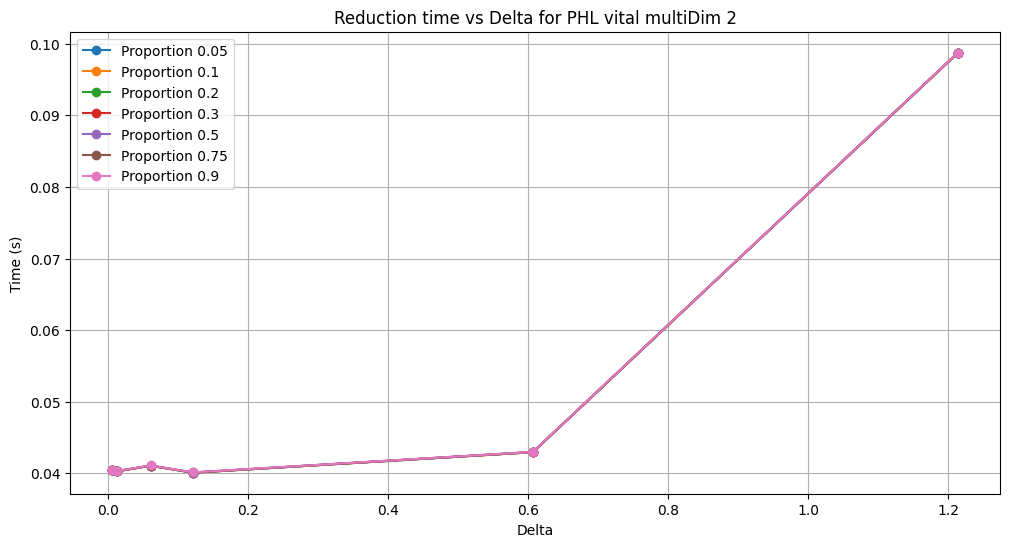

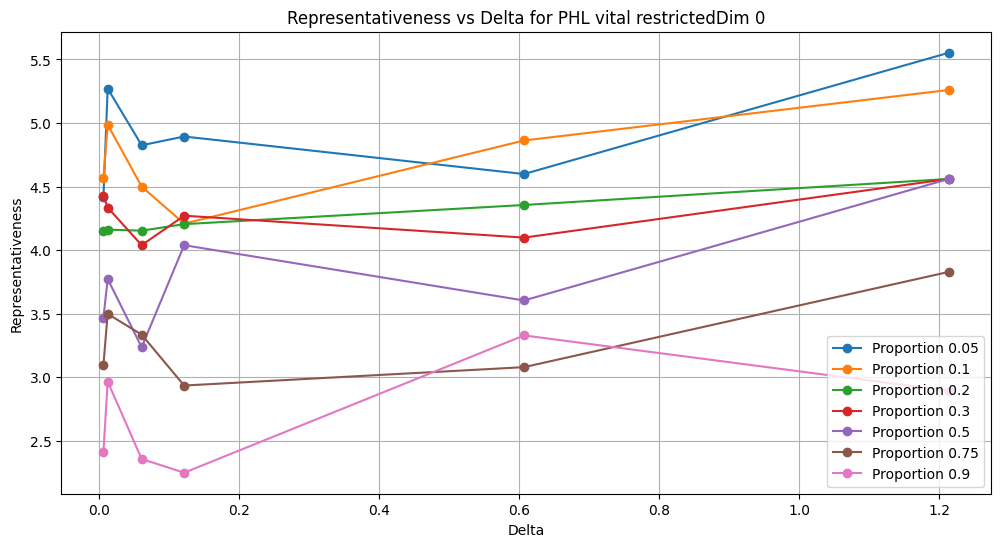

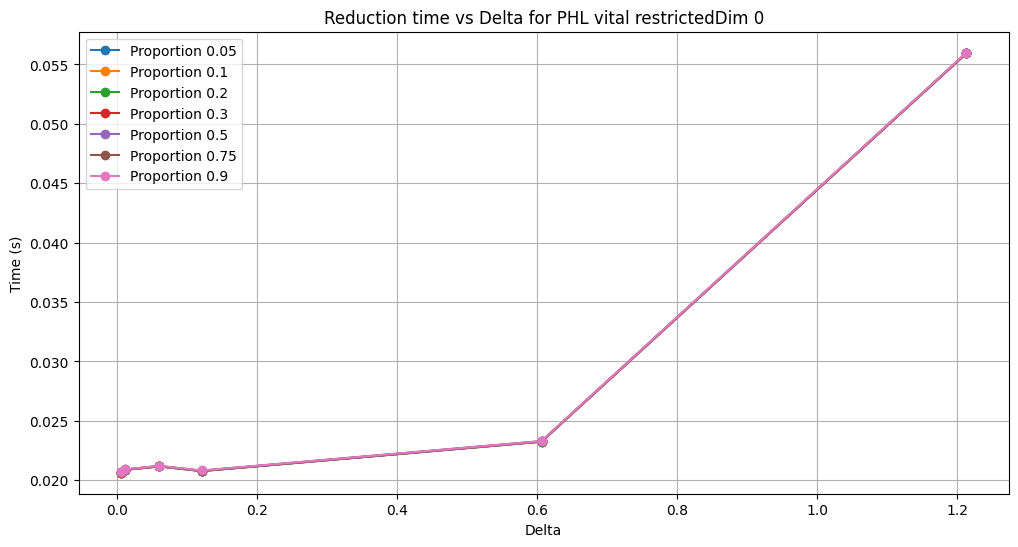

In [40]:
for mode in modes:
    for dimension, scoring_version in dimensions:
        # Get representativeness vs delta averaged by model
        mean_representativeness_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['delta', 'percentage'])['representativeness']
            .mean()
            .reset_index()
        )
        # Get reduction time vs delta averaged by model
        mean_reduction_time_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['delta', 'percentage'])['reduction_time']
            .mean()
            .reset_index()
        )

        # Show representativeness vs delta for each percentage
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['delta'],
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['representativeness'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Representativeness vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Representativeness')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/representativeness_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

        # Show time vs delta
        plt.figure(figsize=(12, 6))
        for percentage in percentages:
            plt.plot(
                mean_reduction_time_phl[mean_reduction_time_phl['percentage'] == percentage]['delta'],
                mean_reduction_time_phl[mean_reduction_time_phl['percentage'] == percentage]['reduction_time'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Reduction time vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Time (s)')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/reduction_time_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

## Comparación de métodos de selección de instancias

In [41]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

results = pd.DataFrame(columns=['model', 'reduction_method', 'percentage'] + metrics)
if os.path.exists(results_folder + '/results.csv'):
    results = pd.read_csv(results_folder + '/results.csv')
else:
    for model_name, model in models.items():
        # Fit the model with the full dataset
        t0 = time.time()
        model.fit(X_train_scaled, y_train)
        t = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        epsilon = 1
        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': 'None',
            'percentage': 1.0,
            'reduction_ratio': 1.0,
            'representativeness': 0,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': t,
            'reduction_time': 0
        }, ignore_index=True)

        # Fit the model with reduced dataset
        for reduction_method, reduce in reduction_methods.items():
            for percentage in percentages:
                # Reduce the dataset
                t0 = time.time()
                X_red, y_red = reduce(X_train_scaled, y_train, percentage)
                reduction_time = time.time() - t0
                
                # Fit the model
                t0 = time.time()
                model = models[model_name]
                model.fit(X_red, y_red)
                training_time = time.time() - t0

                # Evaluate the model
                y_pred_test = model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test, average='weighted')

                # Calculate representativeness
                epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

                # Store the results
                results = results.append({
                    'model': model_name,
                    'reduction_method': reduction_method,
                    'percentage': percentage,
                    'reduction_ratio': len(y_red) / len(y_train),
                    'representativeness': epsilon,
                    'accuracy': accuracy,
                    'f1': f1,
                    'training_time': training_time,
                    'reduction_time': reduction_time,
                }, ignore_index=True)

    # Reduce the dataset with methods that do not require percentage
    for reduction_method, reduce in reduction_methods_without_perc.items():
        # Reduce the dataset
        t0 = time.time()
        X_red, y_red = reduce(X_train_scaled, y_train)
        reduction_time = time.time() - t0

        # Fit the model
        t0 = time.time()
        model = models[model_name]
        model.fit(X_red, y_red)
        training_time = time.time() - t0

        # Evaluate the model
        y_pred_test = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')

        # Calculate representativeness
        epsilon = find_epsilon(X_train_scaled, y_train, X_red, y_red)

        # Store the results
        results = results.append({
            'model': model_name,
            'reduction_method': reduction_method,
            'percentage': 0,
            'reduction_ratio': len(y_red) / len(y_train),
            'representativeness': epsilon,
            'accuracy': accuracy,
            'f1': f1,
            'training_time': training_time,
            'reduction_time': reduction_time,
        }, ignore_index=True)
        
    # Save the results
    results.to_csv(results_folder + 'results.csv', index=False)

In [42]:
results

model reduction_method  percentage  reduction_ratio  representativeness  \
0    KNN             None        1.00         1.000000            0.000000   
1    KNN              SRS        0.05         0.048860            5.336744   
2    KNN              SRS        0.10         0.097720            4.713412   
3    KNN              SRS        0.20         0.198697            4.090081   
4    KNN              SRS        0.30         0.298046            3.550732   
..   ...              ...         ...              ...                 ...   
63   XGB              PHL        0.50         0.498371            3.722782   
64   XGB              PHL        0.75         0.750814            2.743440   
65   XGB              PHL        0.90         0.899023            1.776368   
66   XGB              CNN        0.00         0.241042            7.223817   
67   XGB            DROP3        0.00         0.197068            4.559714   

    accuracy        f1  training_time  reduction_time  
0   0.714286  0.709411       0.000805        0.000000  
1   0.688312  0.682994       0.000397        0.000668  
2   0.655844  0.628049       0.000404        0.000598  
3   0.714286  0.701476       0.000455        0.000615  
4   0.681818  0.672433       0.000470        0.000630  
..       ...       ...            ...             ...  
63  0.785714  0.784838       0.131376        0.022360  
64  0.720779  0.721107       0.149502        0.041454  
65  0.720779  0.719638       0.156428        0.022753  
66  0.590909  0.438961       0.011198        2.317478  
67  0.740260  0.739577       0.020140        0.939044  

[68 rows x 9 columns]

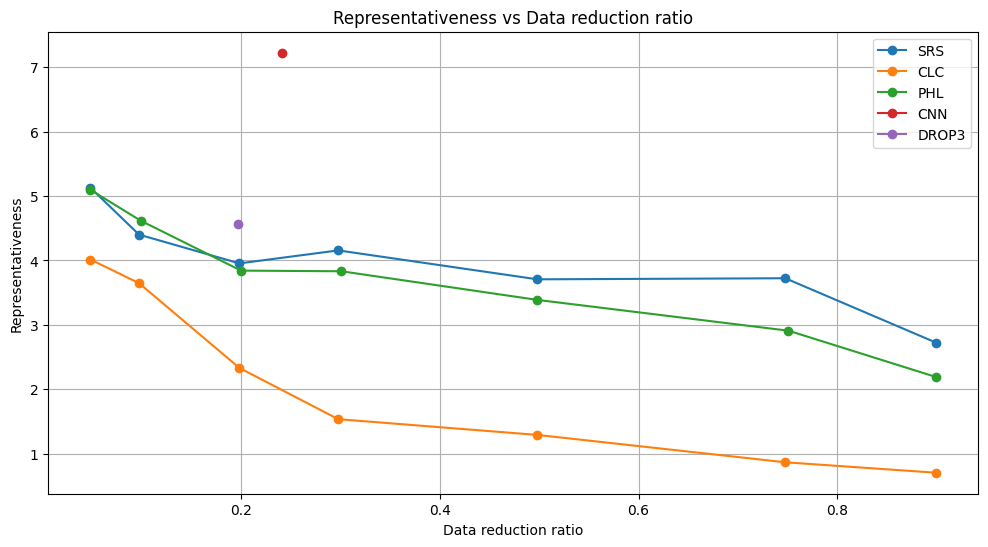

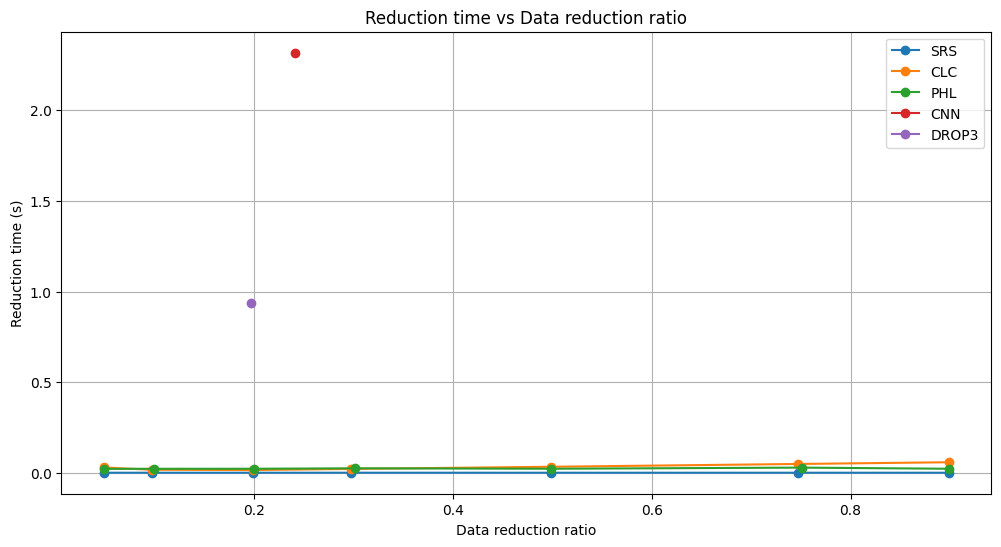

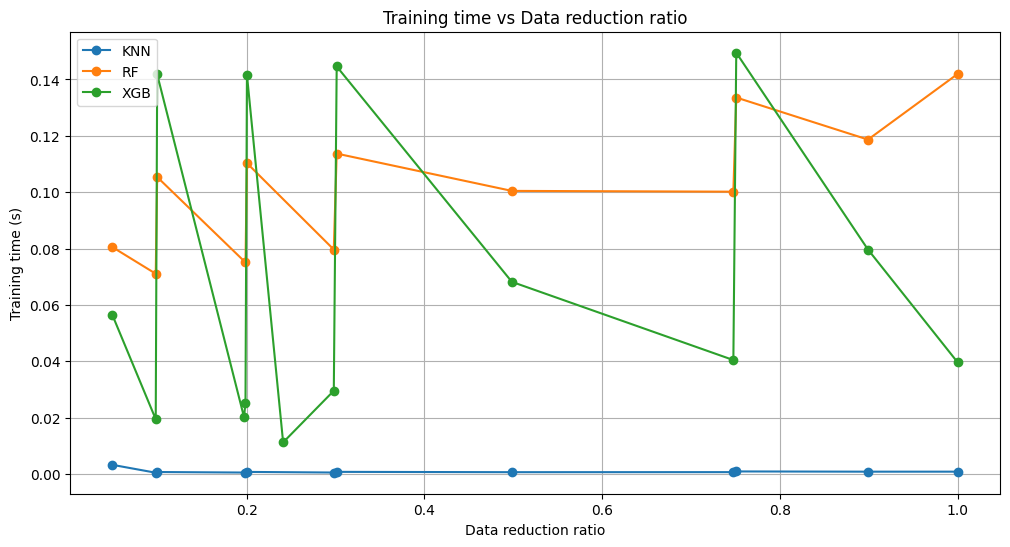

In [43]:
# Mean representativeness vs percentage averaged by model
mean_representativeness = results.groupby(['reduction_method', 'reduction_ratio'])['representativeness'].mean().reset_index()
# Mean reduction time vs percentage averaged by model
mean_reduction_time = results.groupby(['reduction_method', 'reduction_ratio'])['reduction_time'].mean().reset_index()
# Mean training time vs percentage averaged by reduction method
mean_training_time = results.groupby(['model', 'reduction_ratio'])['training_time'].mean().reset_index()

# Plot representativeness vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_representativeness[mean_representativeness['reduction_method'] == reduction_method]['representativeness'],
             label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
plt.show()

# Plot reduction time vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in all_reduction_methods:
    plt.plot(mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_reduction_time[mean_reduction_time['reduction_method'] == reduction_method]['reduction_time'],
             label=reduction_method, marker='o')
    plt.title(f'Reduction time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
plt.show()

# Plot training time vs percentage averaged by reduction method
plt.figure(figsize=(12, 6))
for model_name in models.keys():
    plt.plot(mean_training_time[mean_training_time['model'] == model_name]['reduction_ratio'],
             mean_training_time[mean_training_time['model'] == model_name]['training_time'],
             label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
plt.show()


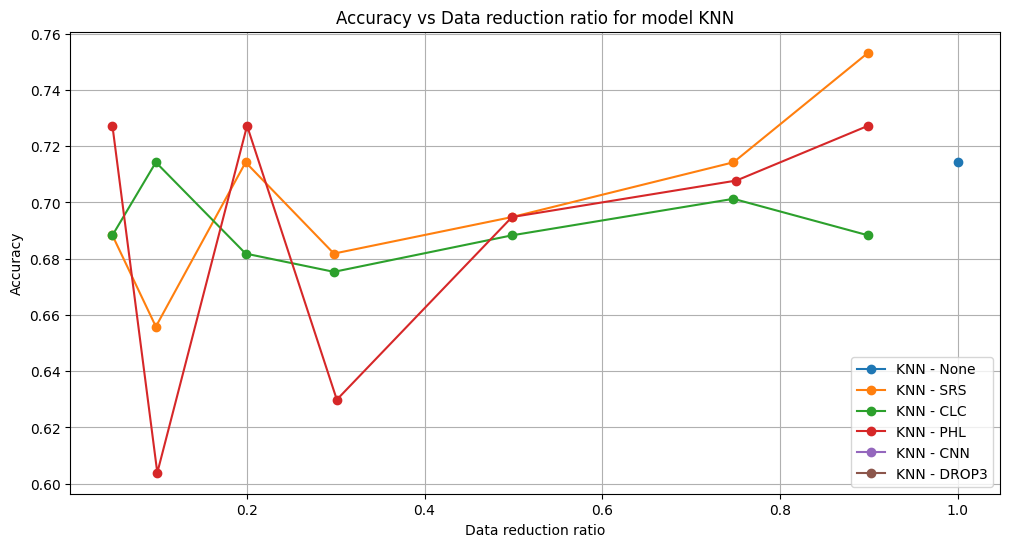

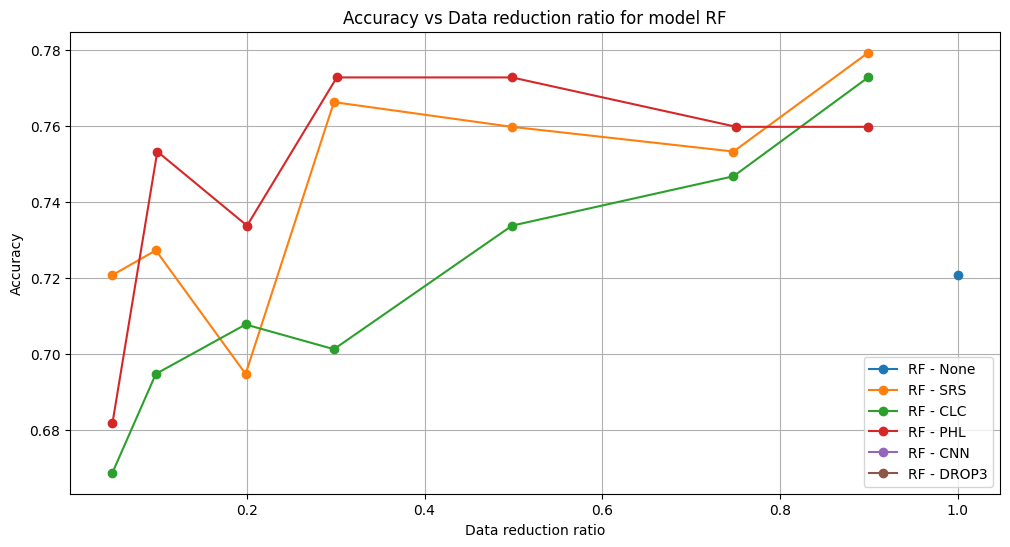

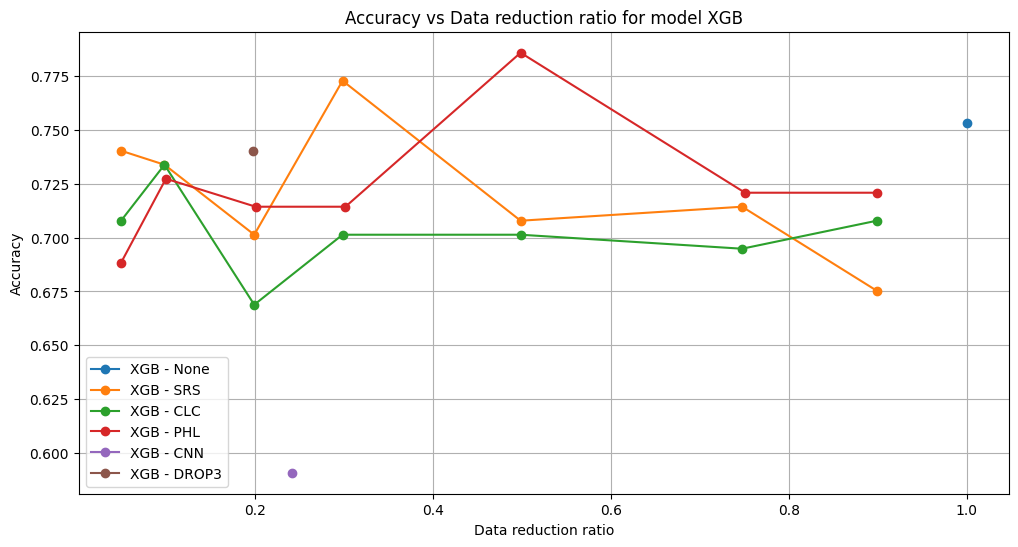

In [44]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
    plt.show()


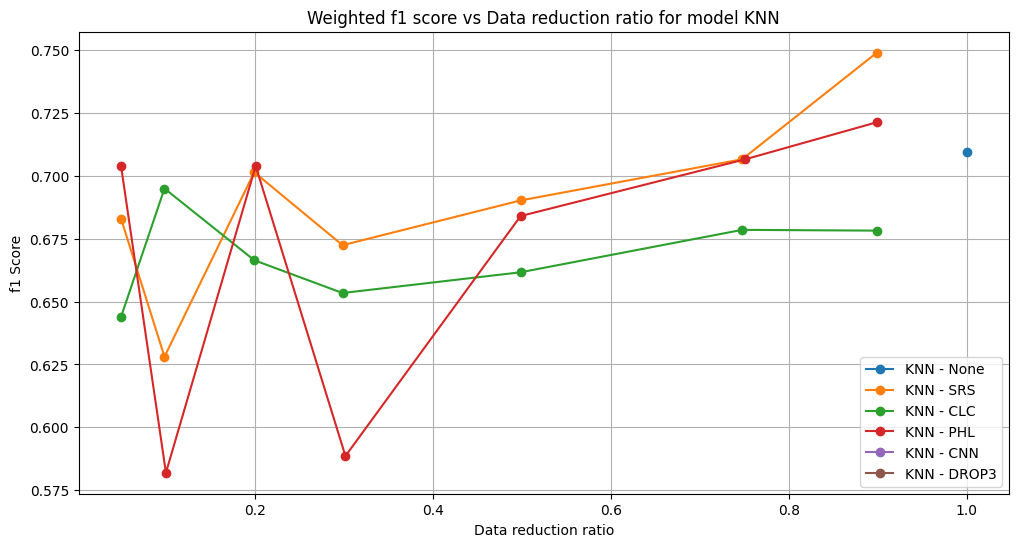

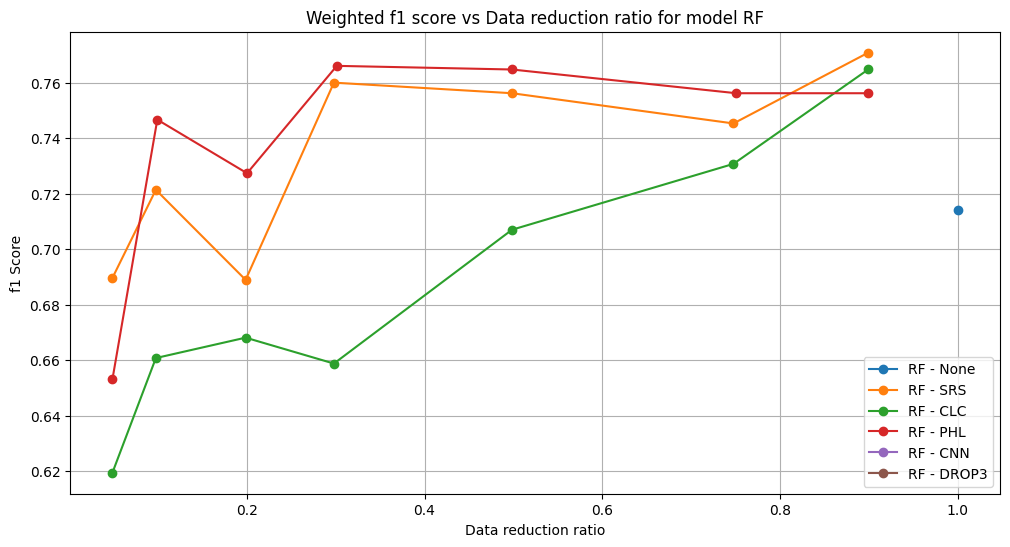

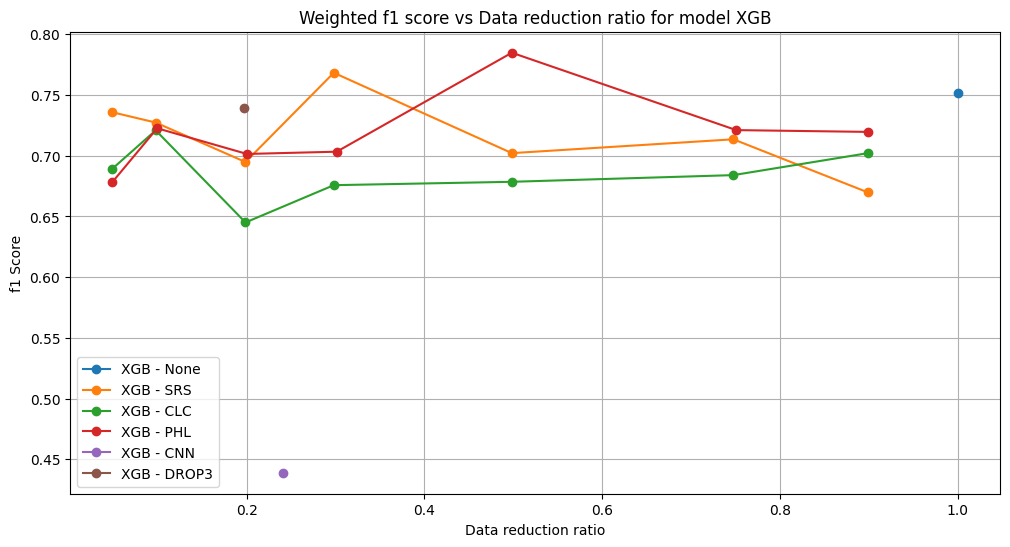

In [45]:
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in all_reduction_methods:
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                 label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
    plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
    plt.show()
